In [1]:
import os
import sys
import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
from torch.autograd import Variable
from torch.optim import Adam, LBFGS
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import json

import adaptiveStrokeNet
from adaptiveStrokeNet import JohnsonAdaptiveStroke

import reversibleEdit
from reversibleEdit.reversible_warping import ReversibleWarpingSine
from reversibleEdit.reversible_swirl import ReversibleSwirl
from reversibleEdit.reversible_rotation import ReversibleRotation

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (14,14)

from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, SelectionSlider, Dropdown



<IPython.core.display.Javascript object>


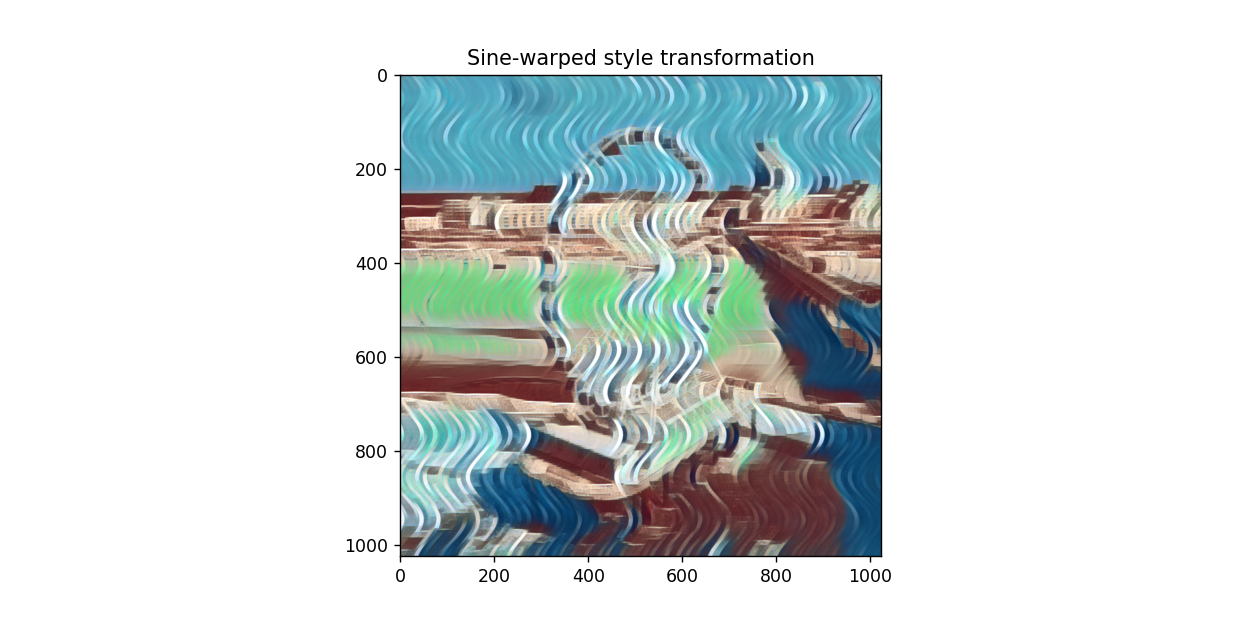

interactive(children=(FloatSlider(value=2.0, description='sine_period', max=4.0, min=0.1), FloatSlider(value=2…

In [2]:
## Reversible sinus warping
CONTENT_IMAGE = "../images/content/ferry.jpg"
OUT = "out.jpg"
STYLE = "giovanni"

REVERSIBLE_EDIT1 = ReversibleWarpingSine()
warping = True
device = torch.device("cuda")
model_path = [f.path for f in os.scandir("../models/adaptiveStroke/" + STYLE) if f.name.endswith(".model")][0]

style_model = JohnsonAdaptiveStroke()
state_dict = torch.load(model_path)
style_model.eval()
style_model.load_state_dict(state_dict)
style_model.to(device)

fig, ax = plt.subplots(figsize=(10, 5))

test_out = np.zeros((1024, 1024, 3)).astype('uint8')
im = ax.imshow(test_out, animated=True)
title = 'Sine-warped style transformation'
plt.title(title)
fig.show()

def warp_sine(sine_period,sine_strength, im, fig):
    with torch.no_grad():
        REVERSIBLE_EDIT1.stretch = sine_period
        REVERSIBLE_EDIT1.amplitude = sine_strength
        REVERSIBLE_EDIT1.horizontal = True
        warped_image = utils.tensor_load_rgbimage(CONTENT_IMAGE, size=1024, rotation=0, keep_asp=True, np_array=True, reversible_edit=REVERSIBLE_EDIT1.forward)
        warped_image = torch.from_numpy(warped_image).float()
        warped_image = warped_image.unsqueeze(0).to(device)
        warped_image = utils.preprocess_batch(warped_image)

        stroke_factor_input = torch.tensor([1.0]).to(device)
        output = style_model(warped_image, stroke_factor_input).float().cpu().squeeze(0)
        img = output.clamp(0,255).numpy()
        img = img.transpose(1,2,0).astype('uint8')
        img = img[:,:,::-1]
        out = REVERSIBLE_EDIT1.backward(img)
        
        im.set_data(out)
        fig.canvas.draw()
        
interactive(warp_sine, 
            sine_period=FloatSlider(min=0.1,max=4.0,value=2.0,step=0.1),
            sine_strength=FloatSlider(min=1.0,max=80.0,value=25.0,step=4.0),
            im=fixed(im), fig=fixed(fig), continuous_update=False)



<IPython.core.display.Javascript object>


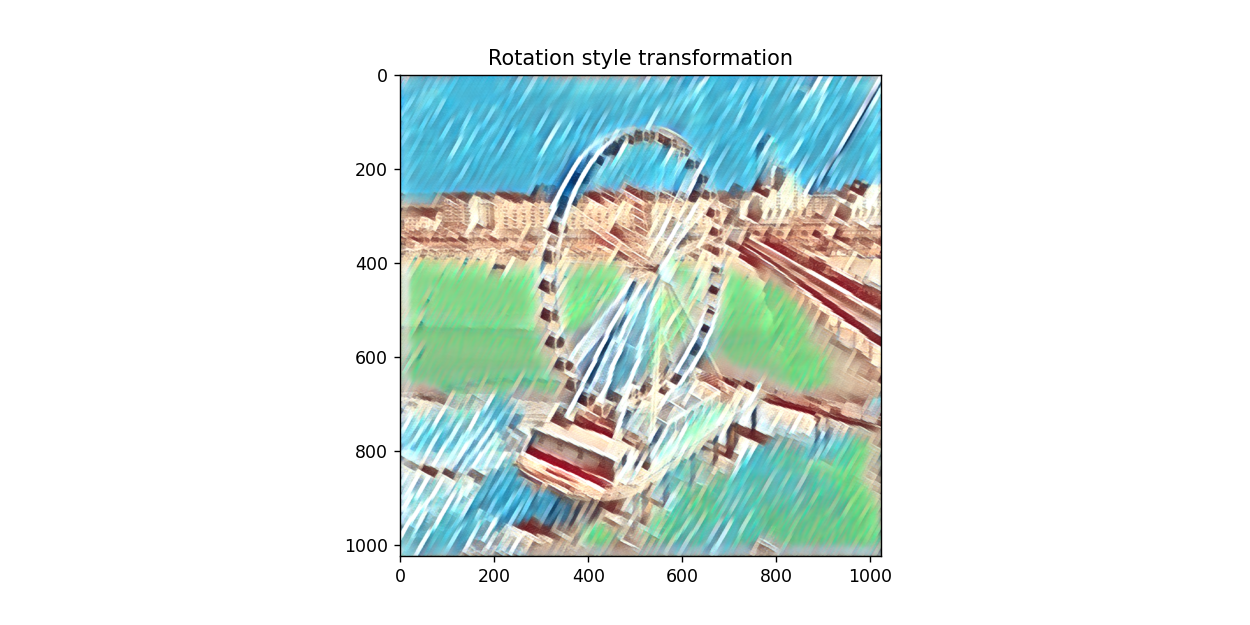

interactive(children=(FloatSlider(value=0.0, description='rot', max=360.0, step=10.0), Output()), _dom_classes…

In [3]:
## Reversible rotation warping
REVERSIBLE_EDIT2 = ReversibleRotation()
fig2, ax2 = plt.subplots(figsize=(10, 5))

test_out = np.zeros((1024, 1024, 3)).astype('uint8')
im2 = ax2.imshow(test_out, animated=True)
title = 'Rotation style transformation'
plt.title(title)
fig2.show()

def warp_rot(rot, im, fig):
    with torch.no_grad():
        REVERSIBLE_EDIT2.rotation = rot
        content_size = 1024 
        upscale_fact = 1
        warped_image = utils.tensor_load_rgbimage(CONTENT_IMAGE, size=1024, keep_asp=True, np_array=True, reversible_edit=REVERSIBLE_EDIT2.forward)
        warped_image = torch.from_numpy(warped_image).float()
        warped_image = warped_image.unsqueeze(0).to(device)
        warped_image = utils.preprocess_batch(warped_image)

        stroke_factor_input = torch.tensor([1.0]).to(device)
        output = style_model(warped_image, stroke_factor_input).float().cpu().squeeze(0)
        img = output.clamp(0,255).numpy()
        img = img.transpose(1,2,0).astype('uint8')
        img = img[:,:,::-1]
        out = REVERSIBLE_EDIT2.backward(img)
        
        im.set_data(out)
        fig.canvas.draw()
        
interactive(warp_rot, 
            rot=FloatSlider(min=0,max=360,value=0.0,step=10),
            im=fixed(im2), fig=fixed(fig2), continuous_update=False)

<IPython.core.display.Javascript object>


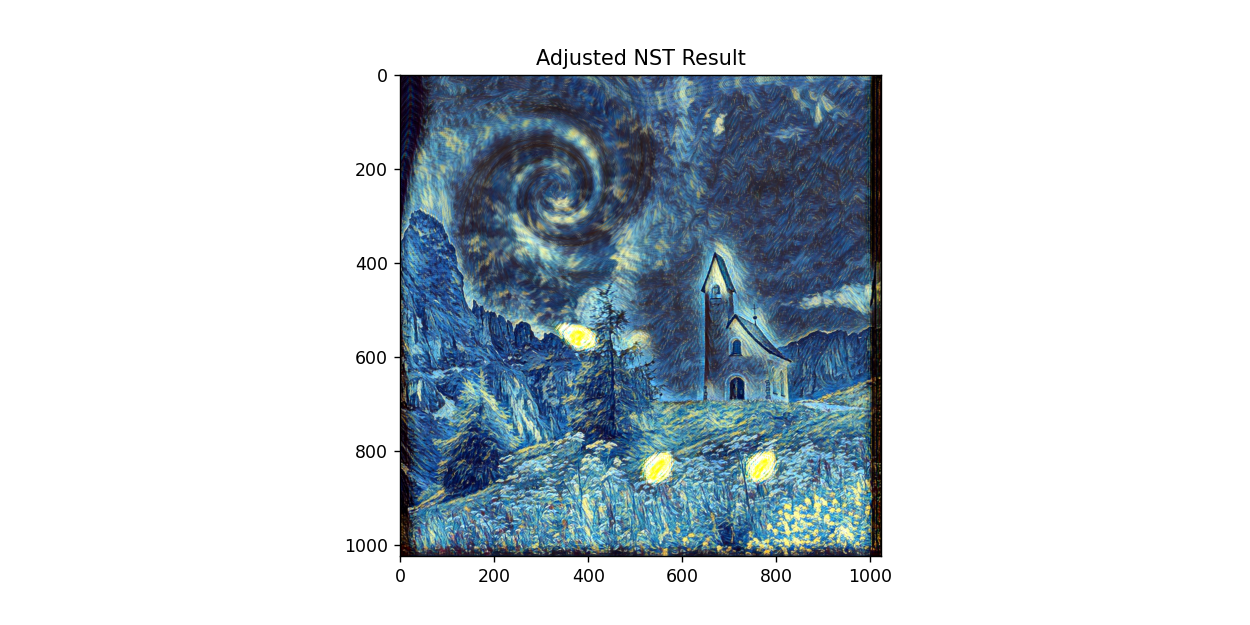

interactive(children=(FloatSlider(value=40.0, description='swirl_strength', max=80.0, min=1.0, step=1.0), Floa…

In [7]:
## Reversible swirl warping
CONTENT_IMAGE = "../images/content/mountain-chapel-crop.jpg"
OUT = "out.jpg"
STYLE = "starry_night"

REVERSIBLE_EDIT = ReversibleSwirl()
warping = True
device = torch.device("cuda")
model_path = [f.path for f in os.scandir("../models/adaptiveStroke/" + STYLE) if f.name.endswith(".model")][0]

style_model = JohnsonAdaptiveStroke()
state_dict = torch.load(model_path)
style_model.eval()
style_model.load_state_dict(state_dict)
style_model.to(device)

fig, ax = plt.subplots(figsize=(10, 5))

test_out = np.zeros((1024, 1024, 3)).astype('uint8')
im = ax.imshow(test_out, animated=True)
title = 'Adjusted NST Result'
plt.title(title)
fig.show()

def swirl_warp(swirl_strength, stroke_factor_strength, radius, x_position, y_position,im, fig):
    global REVERSIBLE_EDIT
    with torch.no_grad():
        REVERSIBLE_EDIT.strength = int(swirl_strength / 4) if swirl_strength <= 40 else 40 - int(swirl_strength / 4)
        REVERSIBLE_EDIT.center = ( x_position, y_position)
        REVERSIBLE_EDIT.radius = radius
        warped_image = utils.tensor_load_rgbimage(CONTENT_IMAGE, size=1024, rotation=0, keep_asp=True, np_array=True, reversible_edit=REVERSIBLE_EDIT.forward)

        warped_image = torch.from_numpy(warped_image).float()
        warped_image = warped_image.unsqueeze(0).to(device)
        warped_image = utils.preprocess_batch(warped_image)

        stroke_factor_input = torch.tensor([stroke_factor_strength]).to(device)
        output = style_model(warped_image, stroke_factor_input).float().cpu().squeeze(0)
        img = output.clamp(0,255).numpy()
        img = img.transpose(1,2,0).astype('uint8')
        img = img[:,:,::-1]
        out = REVERSIBLE_EDIT.backward(img)
        
        im.set_data(out)
        fig.canvas.draw()
        
interactive(swirl_warp, 
            swirl_strength=FloatSlider(min=1.0,max=80.0,value=40.0,step=1.0),
            stroke_factor_strength=FloatSlider(min=0.0,max=2.0,value=1.0,step=0.1),
            radius=IntSlider(min=200,max=1000,value=600,step=100),
            x_position=IntSlider(min=0,max=test_out.shape[0],value=330,step=10),
            y_position=IntSlider(min=0,max=test_out.shape[1],value=250,step=10),
            im=fixed(im), fig=fixed(fig), continuous_update=False)

